# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2021

#### Фамилия, имя: 

Дата выдачи: <span style="color:red">__16 марта 00:00__</span>.

Мягкий дедлайн: <span style="color:red">__30 марта 23:59__</span>.

Стоимость: __10 баллов__ (основная часть заданий) + __4 балла__ (дополнительные задания).

<span style="color:red">__В ноутбуке все клетки должны выполняться без ошибок при последовательном их выполнении.__</span>

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур `Unet` и `Linknet`. 

Данные для выполнения задания можно скачать по [ссылке](https://disk.yandex.ru/d/tI6d3LBMHTwOnw).

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс `PhotosDataset` для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
import torch
import torch.nn as nn

import numpy as np
import numpy.testing as npt

from torchvision.models import vgg13
from torch.utils.data import Dataset, DataLoader

import matplotlib_inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg', 'pdf']

%matplotlib inline
# matplotlib_inline backend_inline.set_matplotlib_formats('pdf', 'svg')

In [2]:
import PIL.Image as Image
import os

class PhotosDataset(Dataset):
    def __init__(self, images_dir, target_dir=None, transforms=None):
        """
        Arguments
        ---------
        images_dir : str
            Path to directory with images
            
        target_dir : str
            Path to directory with masks.
            Each mask corresponds to one image.
            Corresponding mask and image have the same name, but different format.
            
        transforms : some collection
            Sequence of transformations for images and masks. 
        """

        self.transforms = transforms
        self.im_paths = sorted([os.path.join(images_dir, im) for im in os.listdir(images_dir)])
        self.mask_paths = sorted([os.path.join(target_dir, im) for im in os.listdir(target_dir)])

         
    def __len__(self):

        return len(self.im_paths)
                   
    def __getitem__(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index of image and mask
        
        Returns
        -------
        (image, mask)
        """
        
        im = Image.open(self.im_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        for transform in self.transforms:
            im, mask = transform(im, mask)

        return im, mask

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в [документации](https://pytorch.org/vision/0.12/transforms.html).

В данной части вам предлагается самостоятельно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью $p$) горизонтальное отображение (flip) изображения 
* случайное (с вероятностью $p$) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью $p$) изменение яркости изображения (на заданную или случайную величину)
* случайное (с вероятностью $p$) изменение фона изображения (на изображение из заданного списка изображений)

In [3]:
import functools
import torchvision.transforms
import random

def img_and_mask(func, p=1):
    @functools.wraps(func)
    def wrapper(img: Image, mask: Image):
        if random.random() < p:
            return func(img), func(mask)
        else:
            return img, mask
    
    return wrapper

def id_img_and_mask(func, p=1):
    @functools.wraps(func)
    def wrapper(img: Image, mask: Image):
        if random.random() < p:
            return func(img), mask
        
    
    return wrapper

class HorizontalFlip(object):  
    def __init__(self):
        return
              
    def __call__(self, im: Image) -> Image:
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        return im.transpose(Image.FLIP_LEFT_RIGHT)

# class CutPatch(object):
#     def __init__(self, p=0.5, height=None, width=None, left_buttom_point=None):
        

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [4]:
import torchvision.transforms

DATA_PATH = "./people_data/"

train_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'train/',
    target_dir=DATA_PATH + 'train_mask/',
    transforms=[img_and_mask(HorizontalFlip(), p=0.5),
                img_and_mask(torchvision.transforms.ToTensor()),
                id_img_and_mask(torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))]
)

test_dataset = PhotosDataset(
    images_dir=DATA_PATH + 'test/',
    target_dir=DATA_PATH + 'test_mask/',
    transforms=[img_and_mask(HorizontalFlip(), p=0.5),
                img_and_mask(torchvision.transforms.ToTensor()),
                id_img_and_mask(torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))]
)

Функция для отображения изображения:

In [5]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

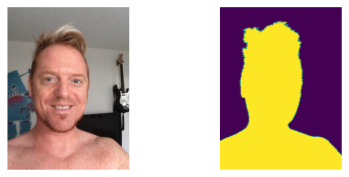

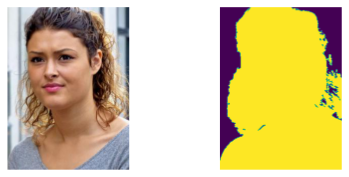

In [6]:
show_idx_image(train_dataset, 19)
show_idx_image(train_dataset, 18)

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры `DataLoader`. При `num_workers`$\;> 1$, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра `shuffle` можно подавать картинки на обучение в случайном порядке.

In [7]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=8)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать функцию потерь `dice` (аналог меры Жаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum\limits_{i, j}a_{ij}b_{ij}}{\sum\limits_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction=None, with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : Optional[str] (None, 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            None: no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = eps
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        """
        logits : tensor
            shape: (N, H, W)
        """
        true_labels = true_labels.long()
        
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        loss_value = 1 - 2 * torch.sum(logits * true_labels, (1, 2)) / torch.sum(logits + true_labels + self.eps, (1,2))

        if self.reduction == 'sum':
            loss_value = torch.sum(loss_value, 0)
        elif self.reduction == 'mean':
            loss_value = torch.mean(loss_value, 0)
        elif  self.reduction is None:
            loss_value = loss_value
            
        return loss_value

Проверка реализации:

In [9]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
])

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
])

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать [UNet](https://arxiv.org/pdf/1505.04597.pdf) с энкодером из первых блоков предобученного `VGG13`. Архитектура сети реализована за вас ниже.

Энкодер:

In [10]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        # Obtaining pretrained VGG model from torchvision.models and
        # copying all layers except for max pooling.
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[
                    feature_extractor[j]
                    for j in range(i * 5, i * 5 + 4)
                ])
            )

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

Декодер:

In [11]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.relu = nn.ReLU()
        
    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.relu(self.conv1(torch.cat([left, x], 1)))
        x = self.relu(self.conv2(x))
        return x

In [12]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

Сеть Unet:

In [13]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

Функция для оценивания качества сети:

In [14]:
def evaluate_net(net, testloader, criterion, val_criterion, device='cpu'):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            
            images = images.to(device)
            
            outputs = net(images).to('cpu')
            total += labels.size(0)
            loss += float(criterion(outputs, labels).detach())
            correct += float(val_criterion(outputs, labels).detach())
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке. 

Сначала при обучении используйте только кросс-энтропию (`torch.nn.BCEWithLogitsLoss` будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). 

Для всех экспериментов отобразите графики функции потерь и качества за время обучения. Выведите получившиеся маски для нескольких изображений из датасета. Сделайте выводы.

In [15]:
# Для оценки качества будем использовать IOU (или Jaccard)

def iou(traget, predict, reduction=None):
    result = torch.sum(traget * predict, (1, 2)) / torch.sum((traget + predict) > 0, (1,2))
    if reduction == "sum":
        result = torch.sum(result, 0)
    if reduction == "mean":
        result = torch.mean(result, 0)
    if reduction == None:
        result = result
    
    return result

In [19]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


In [18]:
import torch.optim as optim
from tqdm.notebook import trange

net = UNet()
optimizer = optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss() 
net.to(device)

loss_curve = []
metric_curve = []
for epoch in trange(100):
    for im, mask in train_data_loader:
        optimizer.zero_grad()
        output = net(im)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
    
    curr_loss, curr_metric = evaluate_net(net, test_data_loader, criterion, iou)
    loss_curve.append(curr_loss)
    metric_curve.append(curr_metric)


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

## LinkNet (2 балла)

Реализуйте архитектуру [LinkNet](https://arxiv.org/pdf/1707.03718.pdf) с использованием энкодера, основанного на `VGG13`. Архитектура похожа на `Unet`, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

Обучите сеть и проведите анализ согласно предыдущему пункту.

In [ ]:
# your code here

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

## Теоретические вопросы (1 балл)

### Вопрос 1.
* Сформулируйте два предположения о структуре входных данных, на которые опирается архитектура свёрточных сетей. 
* Какие преимущества дает использование сверток в случае, если эти предположения верные? 
* Приведите пример входных данных, когда эти предположения не выполняются.

*Ваш ответ в этой ячейке*

### Вопрос 2
Пусть дано множество 1-D входов ${x^{(i)} \in \mathbb{R}^{100}}$. 

Рассмотрим полносвязный слой ${f(\cdot)}$, заданный как ${f(x^{(i)}) = \sigma(Wx^{(i)})}$, где ${W}$ - матрица весов размерности ${1000\times 100}$ и ${\sigma(\cdot)}$ поэлементая функция активации. 

Рассмотрим также сверточный слой ${g(\cdot)}$ с десятью картами признаков: ${g(x^{(i)}) = \sigma([z_1, z_2,...,z_{10}])}$, где ${z_j = x^{(i)}\ast w_j}$ для некоторого ядра свертки ${w_j}$ с размером 3 и паддингом 1. Для ${f(\cdot)}$ и ${g(\cdot)}$ напишите: 

1. Размерность выходного пространства. 
2. Количество обучаемых параметров. 
3. Число операций при выполнении forward pass (при условии наивной реализации перемножения матриц и вычисления сверток).

*Ваш ответ в этой ячейке*

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля [skimage.morphology](https://scikit-image.org/docs/dev/api/skimage.morphology.html)).

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстрируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.

## Бонус: обучение с использованием сторонних фреймворков (1 балл)

Попробуйте обучить свою модель с использованием одного из следующих фреймворков: [catalyst](https://github.com/catalyst-team/catalyst), [pytorch-lightning](https://www.pytorchlightning.ai/), [ignite](https://github.com/pytorch/ignite).